Streaming output truncated to the last 5000 lines.
Sample 238 - True: {'50', '692', '544', '385', '286', '731', '215', '1220', '66', '432', '928'}, Pred: ['286', '100', '50', '181', '288', '258', '151', '1', '300', '222']
Sample 239 - True: {'772', '173', '290', '295', '473', '286', '66'}, Pred: ['286', '100', '50', '181', '288', '258', '151', '300', '1', '222']
Sample 240 - True: {'88', '69', '969', '4', '200', '234', '288', '72', '404', '553', '746', '660', '99', '687', '402', '73'}, Pred: ['286', '100', '50', '181', '288', '258', '151', '1', '300', '222']
Sample 241 - True: {'185', '176', '173', '696', '295', '220', '298', '731', '117', '402'}, Pred: ['286', '100', '50', '181', '288', '258', '151', '1', '300', '222']
Sample 242 - True: {'4', '785', '210', '288', '290', '284', '473', '286', '731', '405', '99', '181', '498'}, Pred: ['286', '100', '50', '181', '288', '258', '151', '1', '300', '222']
Sample 243 - True: {'812', '176', '61', '1040', '174', '696', '288', '295', '385', '79'

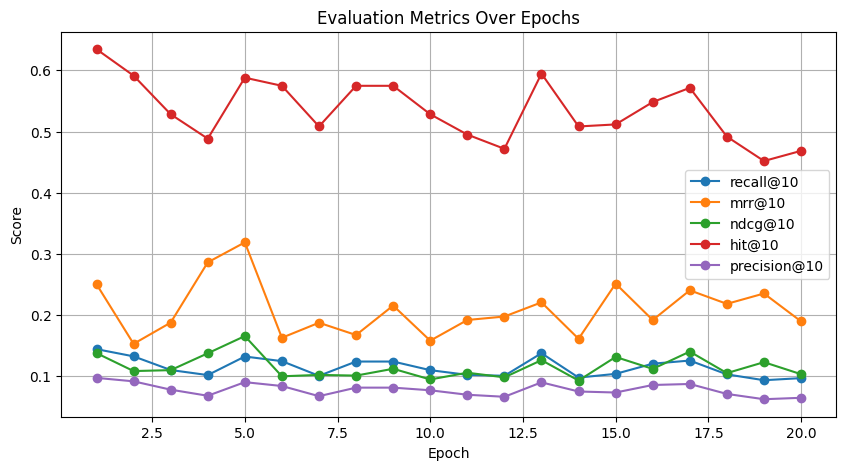

In [2]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)

df = df.sort_values(by=['timestamp'])

# Create item mappings
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows()}

def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

# Identify cold-start users (users present only in test set)
cold_start_users = set(test_df['user_id']) - set(train_df['user_id'])
print(f"Number of cold-start users (only in test set): {len(cold_start_users)}")
train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 512

def mask_items(sequences, mask_prob=0.2):
    masked_sequences, labels = [], []
    for seq in sequences:
        masked_seq = seq[:]
        label = [-1] * len(seq)
        for i in range(len(seq)):
            if np.random.rand() < mask_prob:
                label[i] = masked_seq[i]
                masked_seq[i] = 0

        if all(l == -1 for l in label):
            random_idx = np.random.randint(len(seq))
            label[random_idx] = masked_seq[random_idx]
            masked_seq[random_idx] = 0

        label = [l if l != -1 else 0 for l in label]
        masked_seq = masked_seq[:max_seq_len] + [0] * (max_seq_len - len(masked_seq))
        label = label[:max_seq_len] + [0] * (max_seq_len - len(label))

        masked_sequences.append(masked_seq)
        labels.append(label)
    return np.array(masked_sequences, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = mask_items(train_sequences['item_id'].tolist())
test_input, test_labels = mask_items(test_sequences['item_id'].tolist())

class MaskedLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

gru_units = 129

class SAS4Rec(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=128, num_heads=2, num_layers=2, dropout_rate=0.2):
        super(SAS4Rec, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.positional_encoding = tf.keras.layers.Embedding(input_dim=512, output_dim=hidden_units)
        self.attention_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_units // num_heads)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        seq_length = tf.shape(input_ids)[1]
        positions = tf.range(start=0, limit=seq_length, delta=1)
        x = self.embedding(input_ids) + self.positional_encoding(positions)
        x = self.dropout(x, training=training)
        for attn_layer in self.attention_layers:
            x = attn_layer(x, x, x, training=training)
        logits = self.dense(x)
        return logits

model = SAS4Rec(vocab_size=len(item_to_idx) + 1, hidden_units=128, num_heads=2, num_layers=2, dropout_rate=0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=MaskedLoss(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

def evaluate_metrics(model, test_input, test_labels, top_k=10):
    predictions = model.predict(test_input)
    logits = predictions[:, -1, :]  # Last position logits for all users
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    num_samples = len(test_labels)

    for i in range(num_samples):
        # Convert true item indices to actual item IDs
        true_items = set([idx_to_item[idx] for idx in np.where(test_labels[i] > 0)[0] if idx in idx_to_item])

        # Get top-K predictions, excluding seen items
        pred_items = [
            idx_to_item[int(idx)] for idx in np.argsort(logits[i])[::-1]
            if int(idx) in idx_to_item and idx not in true_items
        ][:top_k]

        pred_items_set = set(pred_items)

        # Debugging: Print actual values
        print(f"Sample {i} - True: {true_items}, Pred: {pred_items}")

        # Compute Metrics
        correct_preds = len(true_items & pred_items_set)
        recall += correct_preds / len(true_items) if len(true_items) > 0 else 0

        for rank, item in enumerate(pred_items, start=1):
            if item in true_items:
                mrr += 1 / rank
                break

        dcg = sum([(1 / np.log2(rank + 2)) if pred_items and pred_items[rank] in true_items else 0 for rank in range(min(len(pred_items), top_k))])
        idcg = sum([1 / np.log2(rank + 2) for rank in range(min(len(true_items), top_k))])
        ndcg += dcg / idcg if idcg > 0 else 0

        hit += int(correct_preds > 0) if pred_items else 0
        precision += correct_preds / top_k if pred_items else 0

    return recall / num_samples, mrr / num_samples, ndcg / num_samples, hit / num_samples, precision / num_samples

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

for epoch in range(20):
    print(f"Epoch {epoch+1}/20")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=16, verbose=1)
    recall, mrr, ndcg, hit, precision = evaluate_metrics(model, test_input, test_labels)
    print(f"Metrics at epoch {epoch+1}:")
    print(f"Recall@10: {recall:.8f}, MRR@10: {mrr:.8f}, NDCG@10: {ndcg:.8f}, Hit@10: {hit:.8f}, Precision@10: {precision:.8f}")
    metrics_history["recall@10"].append(recall)
    metrics_history["mrr@10"].append(mrr)
    metrics_history["ndcg@10"].append(ndcg)
    metrics_history["hit@10"].append(hit)
    metrics_history["precision@10"].append(precision)
    print(metrics_history)

def recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    top_indices = [idx for idx in np.argsort(logits)[::-1] if idx not in watched_items_set][:top_k]

    print(f"Top Recommended Items for User ID {user_id}:")
    recommended_items = []

    for i, idx in enumerate(top_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return recommended_items

def least_recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    bottom_indices = [idx for idx in np.argsort(logits) if idx not in watched_items_set][:top_k]

    print(f"Least Recommended Items for User ID {user_id}:")
    least_recommended_items = []

    for i, idx in enumerate(bottom_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            least_recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return least_recommended_items

recommend_items(user_id=1, top_k=10)
recommend_items(user_id=2, top_k=10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

import json

with open("metrics_history.json", "w") as f:
    json.dump(metrics_history, f, indent=4)

print("Training Completed! Metrics history saved to metrics_history.json")

In [ ]:
!pip install recbole ray kmeans_pytorch optuna wandb surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/